# Code for analyzing volume output
- Uses CSV generated by "collect_volumes.sh" script part of [MAGeTBrain pipeline](https://github.com/CobraLab/documentation/wiki/MAGeTBrain#collecting-volumes) 


In [1]:
import pandas as pd
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import nibabel as nib

sys.path.append('../')
from lib.stats_utils import *

### Paths

In [2]:
project_dir = '../../../'
data_dir = project_dir + 'data/preproc_T1s/'
metadata_dir = '../metadata/'
results_dir = '../results/MAGeT/'

### Participant demographics

In [36]:
participant_df = pd.read_csv('{}participants.csv'.format(metadata_dir))

# exclusions
exclude_subjects = list(participant_df[participant_df['Include in analysis']==0]['Participant_id'])
exclude_subjects = exclude_subjects + ['sub-0123'] # Age unknow ['?']

participant_df = participant_df[~participant_df['Participant_id'].isin(exclude_subjects)]
print('Total number of participants: {} (excluded: {})'.format(len(participant_df),len(exclude_subjects)))

# reformat columns
participant_df['Age'] = participant_df['Age'].astype(np.int)
age_df = participant_df.groupby(['group','Sex'])[['Age']].mean()
sex_df = participant_df.groupby(['group','Sex']).count()['Participant_id']

print(pd.merge(age_df,sex_df,on=['group','Sex']))

## Check preproc subject count

failed_subjects = set(participant_df['Participant_id']) - set(participant_df[participant_df['MAGeT processing']==1]['Participant_id'])
print('\nMAGet failures: {}'.format(failed_subjects))

participant_df[participant_df['Participant_id'].isin(failed_subjects)]

Total number of participants: 113 (excluded: 22)
                 Age  Participant_id
group Sex                           
ET    F    72.600000              10
      M    73.678571              28
NC    F    58.636364              11
      M    55.095238              21
PD    F    62.375000              16
      M    62.259259              27

MAGet failures: {'sub-1120', 'sub-0085', 'sub-4200', 'sub-3600', 'sub-0134', 'sub-1000', 'sub-0109', 'sub-7800', 'sub-0129'}


,Participant_id,Age,Sex,group,Include in analysis,conversion Problem,opteration,T1w,T2w,dwi,...,bold fmap,swi,fmriprep (ses-1) anat only,freesurfer-6.0.1,fmriprep (ses-1) anat + bold prprocessing,T1-QC,T1-template,SUIT () cerebellum segmentation,MAGeT processing,MAGet Comments
40,sub-0109,69,F,PD,1,0,1,3,1,2,...,0,0,1,1,NaN,4,NaN,1,0,NaN
48,sub-0129,69,M,PD,1,0,1,2,1,2,...,0,0,1,1,NaN,4,NaN,1,0,NaN
53,sub-1000,77,M,PD,1,Fixed: dir orgnization problem,1,2,1,2,...,3,0,1,1,NaN,4,NaN,1,0,NaN
63,sub-0134,71,M,ET,1,NaN,1,2,1,2,...,0,0,1,1,1,2,NaN,R1,0,NaN
76,sub-1120,64,M,ET,1,NaN,1-2,1-1,1-1,2-2,...,3-3,2-2,1,1,1,4,NaN,1,0,NaN
87,sub-3600,83,M,ET,1,NaN,1,1,1,2,...,3,2,1,1R,1,4,NaN,1,0,NaN
90,sub-4200,73,F,ET,1,NaN,1,1,1,2,...,3,0,1,1,1,4,NaN,1,0,NaN
96,sub-7800,61,M,ET,1,NaN,1,1,1,2,...,3,2,1,1,1,2,NaN,1,0,NaN
120,sub-0085,53,M,NC,1,NaN,1,1,1,1,...,0,0,1,1,1,2,NaN,1,0,NaN


In [38]:
demograph_columns = ['Participant_id',	'Age',	'Sex',	'group']

analysis_df = participant_df[~participant_df['Participant_id'].isin(failed_subjects)][demograph_columns]
print('Total number of participants in the analysis: {} (excluded failed preproc: {})'.format(len(analysis_df),len(failed_subjects)))
analysis_df.head()

Total number of participants in the analysis: 104 (excluded failed preproc: 9)


,Participant_id,Age,Sex,group
0,sub-0002,70,M,PD
1,sub-0004,76,F,PD
2,sub-0005,45,M,PD
3,sub-0006,63,F,PD
4,sub-0008,59,M,PD


### Grab total brain volumes from the masks

In [13]:
groups = ['NC','ET','PD']

mask_df = pd.DataFrame(columns=['Participant_id','group','brain_volume'])

i = 0
for grp in groups:
    mask_dir = data_dir + '{}/masks/'.format(grp)

    mask_paths = os.listdir(mask_dir)

    for m, mask_path in enumerate(mask_paths):
        sub_name = mask_path.rsplit('-',1)[0]
        mask_path = mask_dir + sub_name + '-brain_mask.nii.gz' 
        
        # load anothor image to mask
        mask = nib.load(mask_path)
        mask_data = mask.get_data()
        mask_df.loc[i] = [sub_name.split('_',1)[0], grp, np.sum(mask_data.ravel())]
        i=i+1
        
mask_df.head()

,Participant_id,group,brain_volume
0,sub-0062,NC,1571150
1,sub-0104,NC,1428372
2,sub-0058,NC,1228322
3,sub-0078,NC,1354347
4,sub-0080,NC,1407550


### Grab cerebellum volumes from segmentations

In [14]:

cols_L = ['L_I_II', 'L_III', 'L_IV', 'L_V', 'L_VI', 'L_Crus_I','L_Crus_II', 'L_VIIB', 'L_VIIIA', 'L_VIIIB', 'L_IX', 'L_X', 'L_CM']
cols_R = ['R_I_II', 'R_III', 'R_IV', 'R_V', 'R_VI', 'R_Crus_I', 'R_Crus_II','R_VIIB', 'R_VIIIA', 'R_VIIIB', 'R_IX', 'R_X', 'R_CM']

vol_df_concat = pd.DataFrame()
for grp in groups:
    vol_df = pd.read_csv('{}{}_volumes.csv'.format(results_dir,grp))
    vol_df['group'] = grp
    vol_df['Participant_id'] = vol_df['Subject'].str.split('_',expand=True)[0].str.split('/',expand=True)[1]
    vol_df['L_CB'] = vol_df[cols_L].sum(axis=1)
    vol_df['R_CB'] = vol_df[cols_R].sum(axis=1)
    vol_df_concat = vol_df_concat.append(vol_df)

vol_df_concat = pd.merge(vol_df_concat,mask_df,on=['Participant_id','group'],how='left')

# sort and count group sizes
vol_df_concat = vol_df_concat.sort_values(['group','Participant_id'])
group_sizes = vol_df_concat.value_counts(['group'])
print('Number of Participant_ids:\n{}'.format(group_sizes))

h_lines = np.cumsum(group_sizes.sort_index().values)[:-1]
v_lines = len(cols_L)

print('hlines: {}, vlines: {}'.format(h_lines,v_lines))

vol_df_concat.head()

Number of Participant_ids:
group
PD       47
ET       34
NC       33
dtype: int64
hlines: [34 67], vlines: 13


,Subject,L_I_II,L_III,L_IV,L_V,L_VI,L_Crus_I,L_Crus_II,L_VIIB,L_VIIIA,...,R_VIIIA,R_VIIIB,R_IX,R_X,R_CM,group,Participant_id,L_CB,R_CB,brain_volume
34,./sub-0016_ses-1_run-1_desc-masked_preproc_T1w...,75.0,979.0,2700.0,4822.0,8896.0,11257.0,9249.0,3517.0,6107.0,...,4448.0,3894.0,4662.0,599.0,7896.0,ET,sub-0016,64478.0,67298.0,1475141
33,./sub-0061_ses-1_run-1_desc-masked_preproc_T1w...,54.0,831.0,2519.0,3625.0,7201.0,10349.0,7570.0,3509.0,5316.0,...,3928.0,3239.0,2699.0,513.0,7526.0,ET,sub-0061,54314.0,57865.0,1400053
35,./sub-0081_ses-1_run-1_desc-masked_preproc_T1w...,125.0,895.0,2316.0,3468.0,6315.0,11410.0,6663.0,2828.0,5304.0,...,3606.0,3250.0,2911.0,632.0,6759.0,ET,sub-0081,53619.0,57589.0,1319141
36,./sub-0115_ses-1_run-1_desc-masked_preproc_T1w...,56.0,744.0,2294.0,3441.0,5420.0,9979.0,7227.0,3205.0,5493.0,...,3883.0,3039.0,3486.0,554.0,6684.0,ET,sub-0115,51463.0,54601.0,1245352
37,./sub-0119_ses-1_run-1_desc-masked_preproc_T1w...,81.0,761.0,2063.0,3946.0,7193.0,11504.0,5921.0,2631.0,5290.0,...,3689.0,3378.0,2805.0,539.0,7418.0,ET,sub-0119,53280.0,56064.0,1340808


## Plots

### Total volumes: Individuals
- Cerebellum (L and R) compared with TBV

Normalizing cerebellum volume with TBV


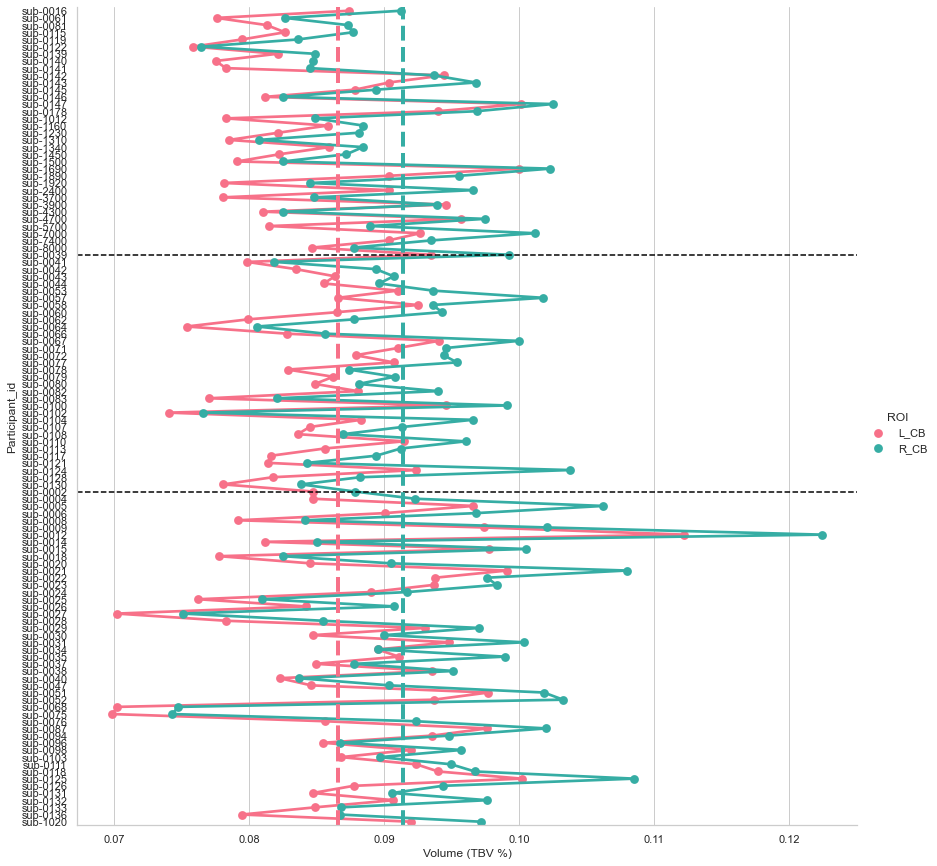

In [15]:
plot_df = vol_df_concat.copy()
plot_df[['Participant_id','group','L_CB','L_CB','brain_volume']]

normalize = True

if normalize:
    print('Normalizing cerebellum volume with TBV')
    plot_df['L_CB'] = plot_df['L_CB']/(0.5*plot_df['brain_volume'])
    plot_df['R_CB'] = plot_df['R_CB']/(0.5*plot_df['brain_volume'])

vol_min = np.min(plot_df[['L_CB','R_CB']].values)
vol_max = np.max(plot_df[['L_CB','R_CB']].values)
L_CB_mean = np.mean(plot_df[['L_CB']].values)
R_CB_mean = np.mean(plot_df[['R_CB']].values)

palette = sns.color_palette('husl',2)

with sns.axes_style("whitegrid"):
    plot_df = pd.melt(plot_df, id_vars = ['Participant_id','group','brain_volume'], value_vars = ['L_CB','R_CB'] , 
                      var_name ='ROI', value_name ='volume')
    g = sns.catplot(x='volume', y='Participant_id', hue='ROI', kind='point',aspect=1, height=12, palette = palette,
                    data=plot_df)

    for h_line in h_lines:
        plt.axhline(h_line, ls='--',c='black')

    plt.axvline(L_CB_mean, ls='--',lw=4, c=palette[0])
    plt.axvline(R_CB_mean, ls='--',lw=4, c=palette[1])
    # g.set_xticklabels(rotation=50)
    if normalize:
        plt.xlabel('Volume (TBV %)')

### Total volumes: Group comparisons

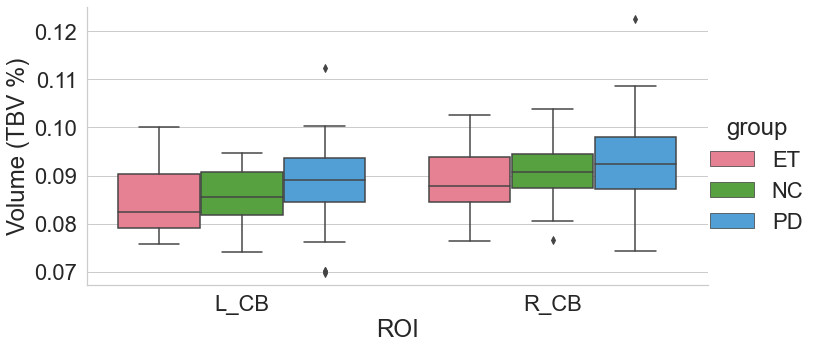

In [16]:
sns.set(font_scale=2)
palette = sns.color_palette('husl',3)
with sns.axes_style("whitegrid"):
    g = sns.catplot(y='volume', x='ROI', hue='group', kind='box',aspect=2, height=5, palette = palette,
                    data=plot_df)
    if normalize:
        plt.ylabel('Volume (TBV %)')

### ROI volumes

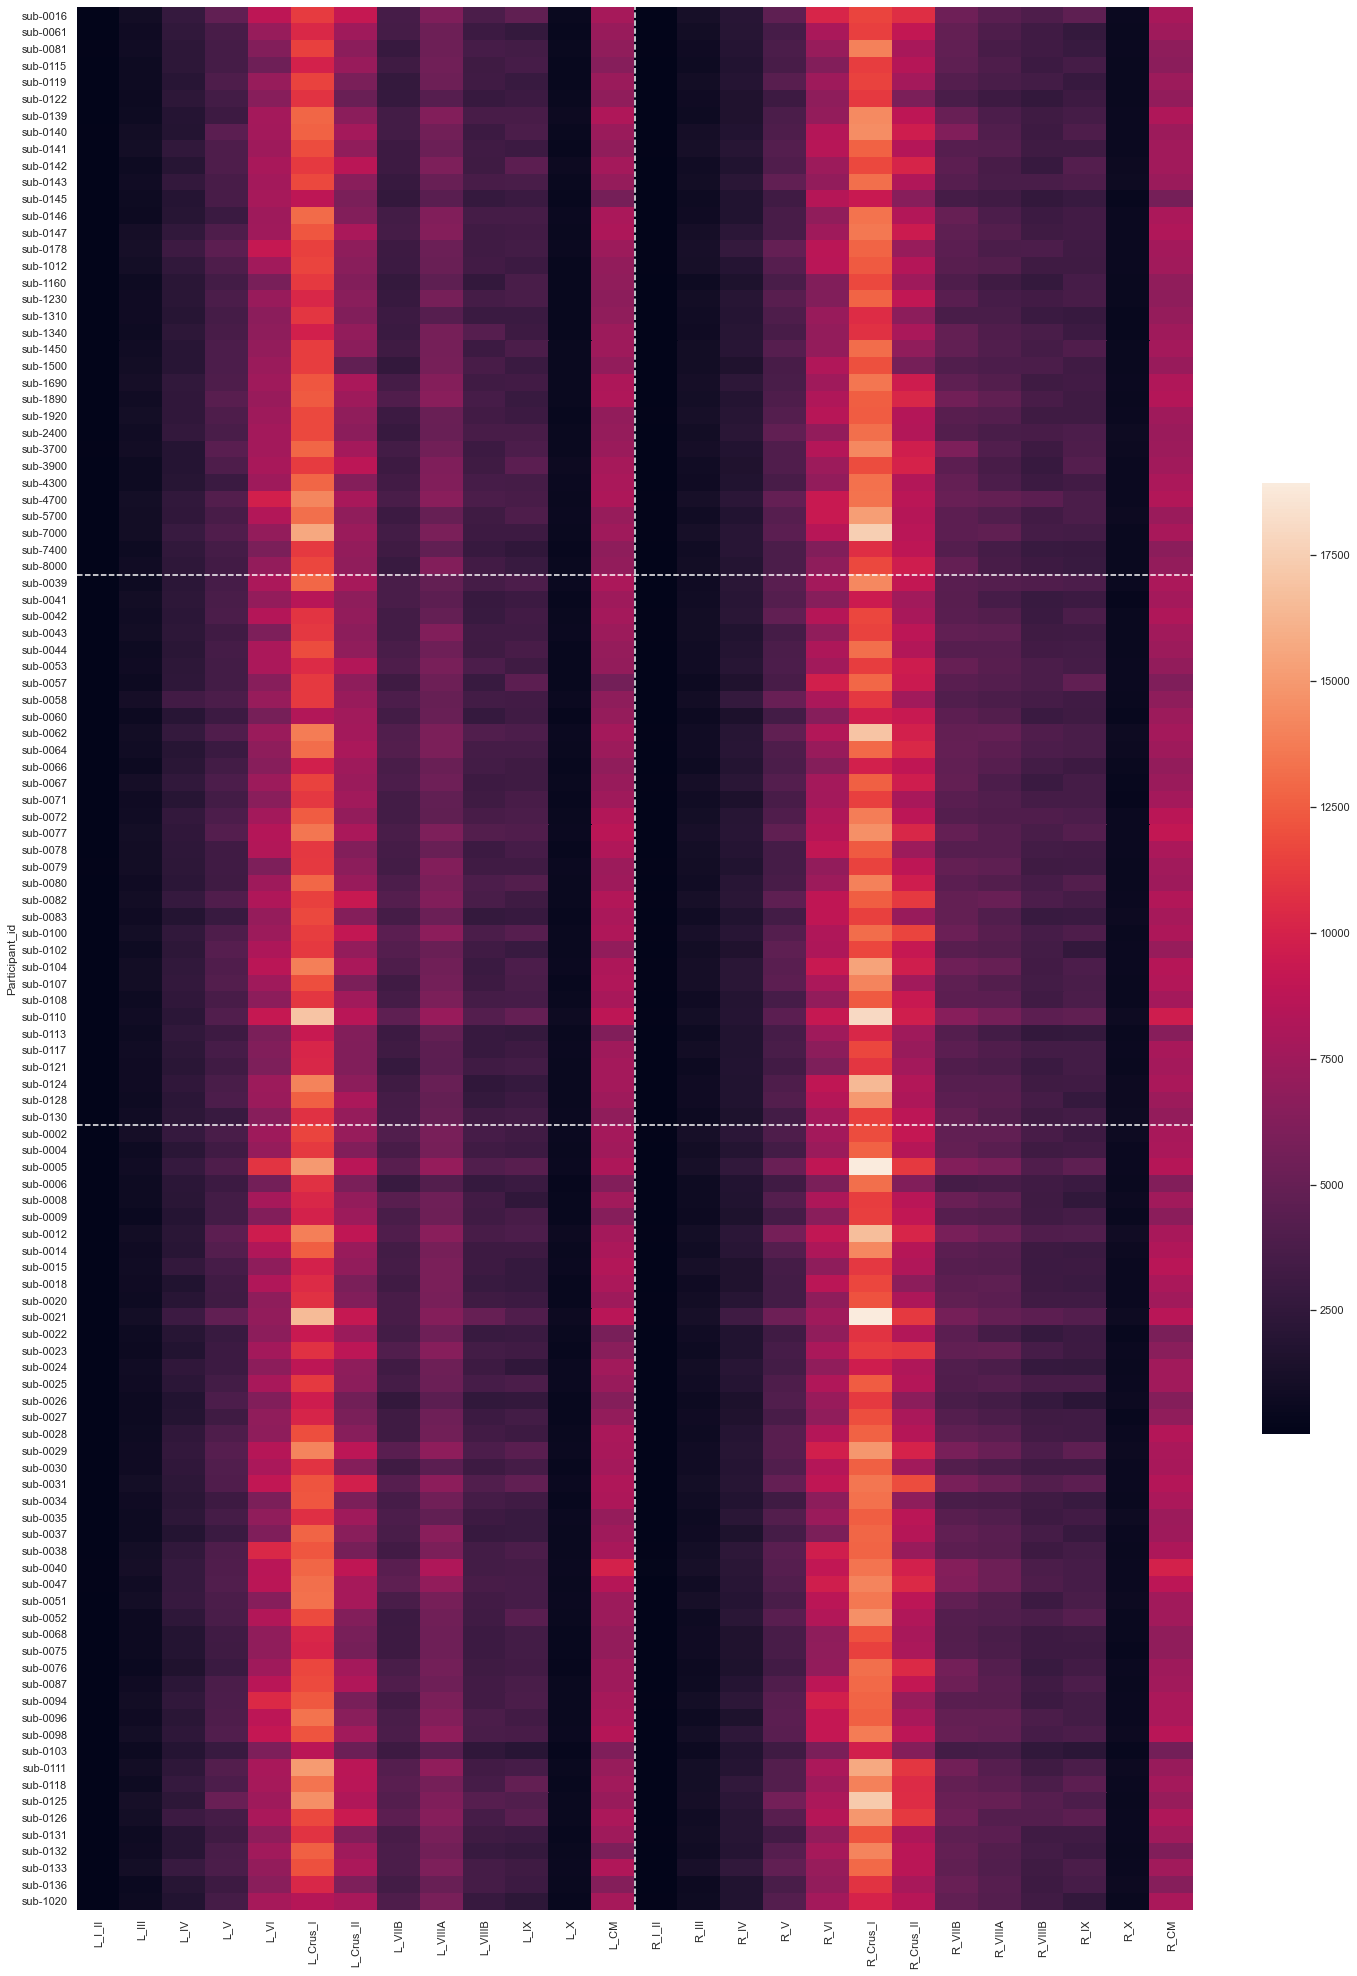

In [17]:
plot_df = vol_df_concat.copy()
plot_df = plot_df.set_index('Participant_id')
plot_df = plot_df[cols_L + cols_R ]
sns.set(font_scale=1)
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(25, 35))
    g = sns.heatmap(plot_df,cbar_kws={"shrink": .5})

    for h_line in h_lines:
        plt.axhline(h_line, ls='--',c='white')
    plt.axvline(v_lines, ls='--',c='white')

### Group comparisons

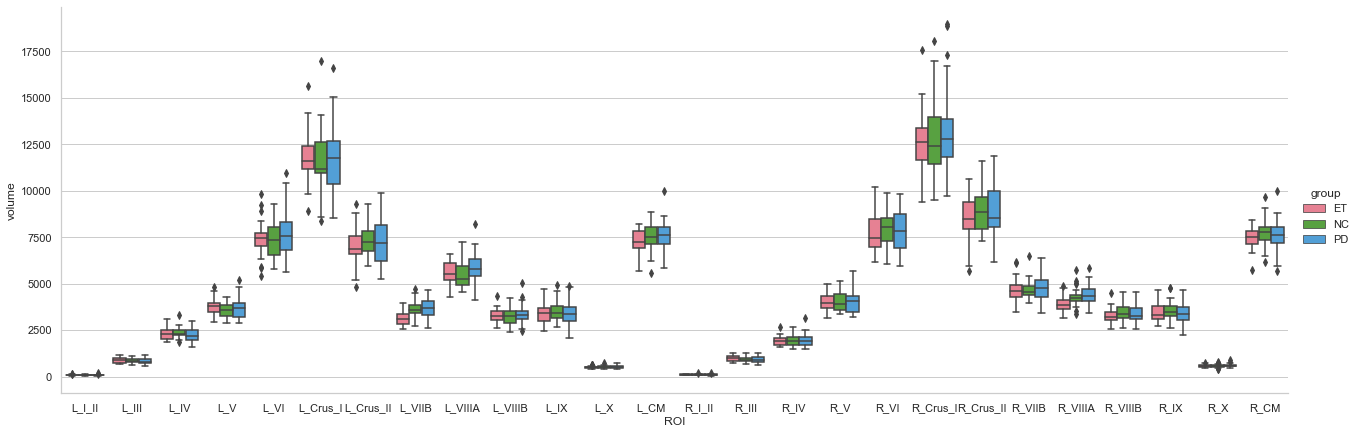

In [18]:
plot_df = vol_df_concat.copy()
plot_df = plot_df[['Participant_id','group'] + cols_L + cols_R]

palette = sns.color_palette('husl',3)
with sns.axes_style("whitegrid"):
    plot_df = pd.melt(plot_df, id_vars = ['Participant_id','group'], value_vars = cols_L + cols_R, 
                      var_name ='ROI', value_name ='volume')
    g = sns.catplot(y='volume', x='ROI', hue='group', kind='box',aspect=3, height=6, palette=palette,
                    data=plot_df)

 

## OLS
- Find signficant difference between NC, ET, PD groups based on ROI volumes
- Correct for multiple comparison

In [46]:
stat_df = pd.merge(vol_df_concat,analysis_df,on=['Participant_id','group'],how='inner')
print('Total number of participants in the analysis after volume {} + demo merge {}: {}'.format(len(vol_df_concat),len(analysis_df),len(stat_df)))

stat_cols = cols_L+cols_R+['L_CB', 'R_CB', 'brain_volume','Age']

stat_df[stat_cols] = stat_df[stat_cols].astype(int)

# regression (# check model with Age only)
independent_var = 'C(group, Treatment(reference=\'NC\'))' #'Age'
compare_levels =  ['C(group, Treatment(reference=\'NC\'))[T.ET]','C(group, Treatment(reference=\'NC\'))[T.PD]'] #'Age'
covars = 'brain_volume + Age + C(Sex)' #'brain_volume + C(Sex)' 

res_df_concat = pd.DataFrame()
for dependent_var in cols_L + ['L_CB'] + cols_R + ['R_CB']:
    res = smf.ols(formula='{} ~ {} + {}'.format(dependent_var, covars, independent_var), data=stat_df).fit()
    res_df = format_ols_results(res)
    res_df['dependent_var'] = dependent_var
    res_df_concat = res_df_concat.append(res_df)

res_df_concat.head()

Total number of participants in the analysis after volume 114 + demo merge 104: 104


,index,coef,std err,t,P>|t|,[0.025,0.975],R2,R2_adj,dependent_var
0,Intercept,-13.873400,29.637000,-0.468,0.641,-72.688000,44.941,0.186309,0.144794,L_I_II
1,C(Sex)[T.M],3.609400,5.322000,0.678,0.499,-6.953000,14.171,0.186309,0.144794,L_I_II
2,"C(group, Treatment(reference='NC'))[T.ET]",5.382200,6.827000,0.788,0.432,-8.165000,18.929,0.186309,0.144794,L_I_II
3,"C(group, Treatment(reference='NC'))[T.PD]",-2.300000,5.297000,-0.434,0.665,-12.812000,8.212,0.186309,0.144794,L_I_II
4,brain_volume,0.000068,0.000021,3.280,0.001,0.000027,0.000,0.186309,0.144794,L_I_II


Using corrected p-val threshold of 0.00
signficant ROIs: ['L_VIIIA']


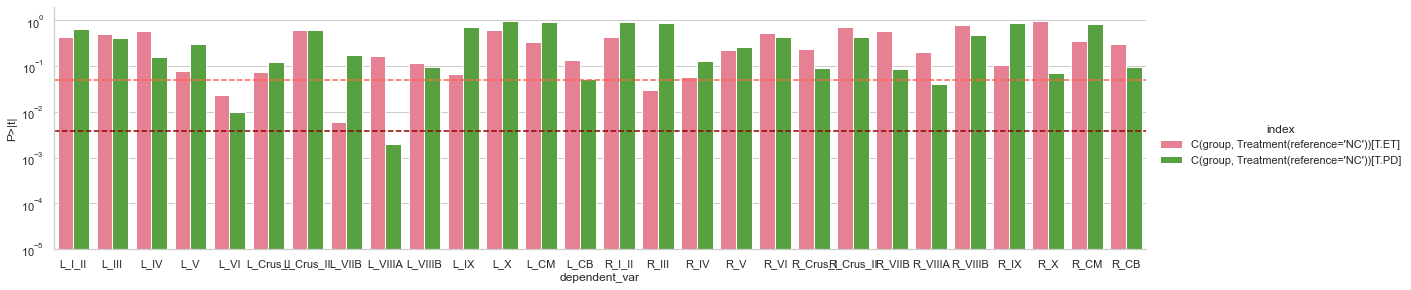

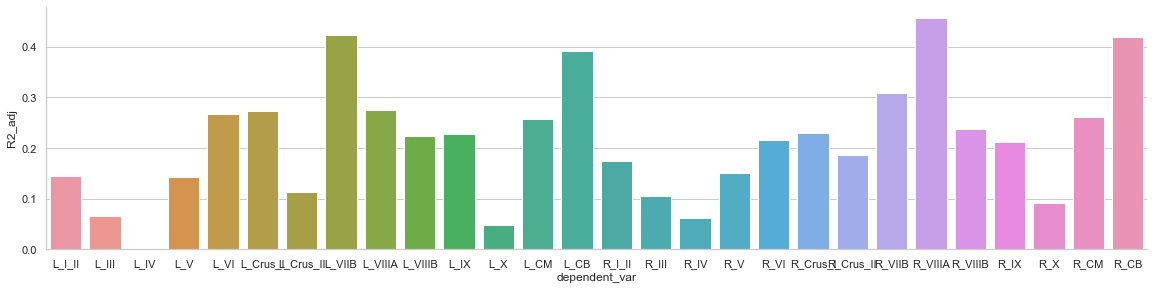

In [56]:
plot_df = res_df_concat[res_df_concat['index'].isin(compare_levels)].copy()
n_compare = len(cols_L) #len(cols_L+cols_R)
signific_thesh = 0.05/(n_compare)
print('Using corrected p-val threshold of {:3.2f}'.format(signific_thesh))

signific_ROIs = plot_df[plot_df['P>|t|'] < signific_thesh]['dependent_var'].values
print('signficant ROIs: {}'.format(signific_ROIs))

with sns.axes_style("whitegrid"):
    g = sns.catplot(y='P>|t|', x='dependent_var', kind='bar', hue='index', aspect=4, height=4, palette=palette,
                    data=plot_df)
    g.set(yscale='log',ylim=(1e-5,2))
    plt.axhline(0.05, ls='--',c='tomato')
    plt.axhline(signific_thesh, ls='--',c='darkred')

with sns.axes_style("whitegrid"):
    g = sns.catplot(y='R2_adj', x='dependent_var', kind='bar', aspect=4, height=4, 
                    data=plot_df)

In [57]:
signific_df = res_df_concat[res_df_concat['dependent_var'].isin(signific_ROIs)]
signific_df

,index,coef,std err,t,P>|t|,[0.025,0.975],R2,R2_adj,dependent_var
0,Intercept,2801.8009,860.284,3.257,0.002,1094.595,4509.007,0.310985,0.275832,L_VIIIA
1,C(Sex)[T.M],251.3286,154.492,1.627,0.107,-55.256,557.913,0.310985,0.275832,L_VIIIA
2,"C(group, Treatment(reference='NC'))[T.ET]",276.0086,198.157,1.393,0.167,-117.228,669.245,0.310985,0.275832,L_VIIIA
3,"C(group, Treatment(reference='NC'))[T.PD]",493.6463,153.764,3.210,0.002,188.507,798.786,0.310985,0.275832,L_VIIIA
4,brain_volume,0.0023,0.001,3.784,0.000,0.001,0.003,0.310985,0.275832,L_VIIIA
5,Age,-9.6688,6.941,-1.393,0.167,-23.444,4.106,0.310985,0.275832,L_VIIIA
